In [1]:
!pip install nipy
!pip install nilearn
%matplotlib inline
from google.colab import files
import nipy
import matplotlib
import numpy as np
import matplotlib.pyplot as plt

from nipy.modalities.fmri.hrf import spm_hrf_compat
from nipy.modalities.fmri.hrf import ddspmt
from nipy.modalities.fmri.hrf import dspmt
from nipy.modalities.fmri.hrf import spmt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 2.3 MB 5.3 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 9.6 MB 5.7 MB/s 
     |████████████████████████████████| 38.1 MB 1.6 MB/s 
  Attempting uninstall: scipy
    Found existing installation: scipy 1.4.1
    Uninstalling scipy-1.4.1:
      Successfully uninstalled scipy-1.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
albumentations 0.1.12 requires imgaug<0.2.7,>=0.2.5, but you have imgaug 0.2.9 which is incompatible.


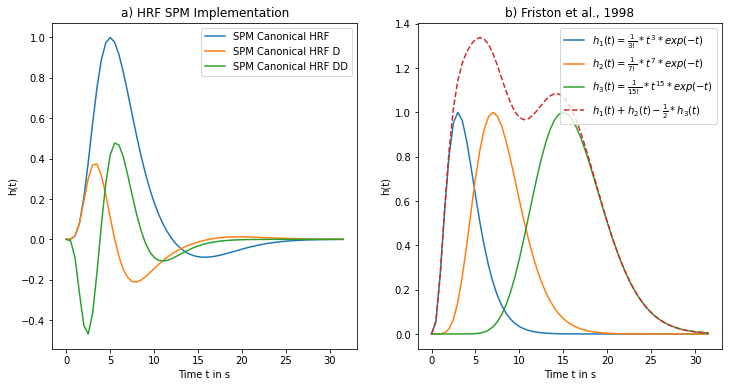

In [3]:
# Friston et al., 1998
def h1(t):
  hh = (1.0/6.0)*(t**3)*np.exp(-t)
  return hh/np.max(hh)

def h2(t):
  hh = (1.0/5040.0)*(t**7)*np.exp(-t)
  return hh/np.max(hh)

def h3(t):
  hh = (1.0/1.3077e+12)*(t**15)*np.exp(-t)
  return hh/np.max(hh)

# Lindquist et al., 2009
def sigmoid(x):
  return 1 / (1 + math.exp(-x))

# Boynton et al., Glover et al., Friston et al. one Gamma HRF model
t = np.arange(0,32.0,0.5)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,6])
hrf1=spmt(t)/spmt(t).max()
hrf2=dspmt(t)/spmt(t).max()
hrf3=ddspmt(t)/spmt(t).max()
ax1.plot(t,hrf1, label='SPM Canonical HRF')
ax1.plot(t,hrf2,label='SPM Canonical HRF D')
ax1.plot(t,hrf3,label='SPM Canonical HRF DD')
ax1.set_xlabel('Time t in s')
ax1.set_ylabel('h(t)')
ax1.set_title('a) HRF SPM Implementation')
ax1.legend()

ax2.plot(t,h1(t),label=r"$h_1(t)=\frac{1}{3!}*t^3*exp(-t)$")
ax2.plot(t,h2(t),label=r"$h_2(t)=\frac{1}{7!}*t^7*exp(-t)$")
ax2.plot(t,h3(t),label=r"$h_3(t)=\frac{1}{15!}*t^{15}*exp(-t)$")
ax2.plot(t,h1(t)+h2(t)+h3(t),'--',label=r"$h_1(t)+h_2(t)-\frac{1}{2}*h_3(t)$")
ax2.set_xlabel('Time t in s')
ax2.set_ylabel('h(t)')
ax2.set_title('b) Friston et al., 1998')
ax2.legend()

#filename = 'HRFs.png'
#f.savefig(filename)
#files.download(filename)

[ 0.58007855  0.60468221 -0.13427372]


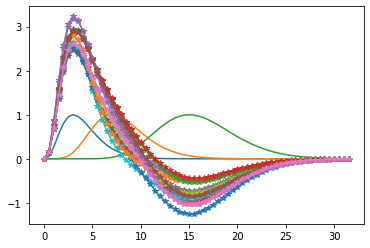

In [4]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
X = np.concatenate([h1(t)[:,None],h2(t)[:,None],h3(t)[:,None]],axis=1)
Y = spm_hrf_compat(t,normalize=False)/np.max(spm_hrf_compat(t,normalize=False))
regr.fit( X, Y)
print(regr.coef_)
#plt.plot(t,spm_hrf_compat(t,normalize=False)/np.max(spm_hrf_compat(t,normalize=False)), '--', label='SPM Canonical HRF')
plt.plot(t,h1(t),label=r"$h_1(t)=\frac{1}{3!}*t^3*exp(-t)$")
plt.plot(t,h2(t),label=r"$h_2(t)=\frac{1}{7!}*t^7*exp(-t)$")
plt.plot(t,h3(t),label=r"$h_3(t)=\frac{1}{15!}*t^{15}*exp(-t)$")
from numpy.random import randn
for i in range(14):
  plt.plot(t,X.dot(np.array([2.7+0.25*randn(1),0.34+0.25*randn(1),-0.7+0.25*randn(1)])),'-*',label=r"$h_1(t)+h_2(t)-\frac{1}{2}*h_3(t)$")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

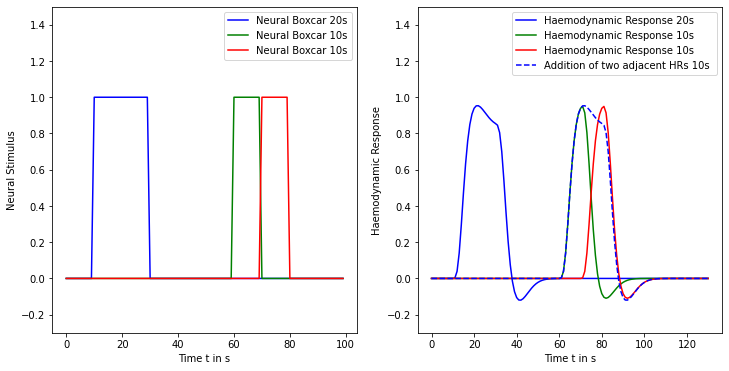

In [5]:
# a linear time-invariant system satisfies the three properties of addition, scaling and shift-invariants as we'll demonstrate in the following  
dt=1
x = np.arange(0,100,dt)
n = np.zeros(len(x))
n1 = np.copy(n)
n2 = np.copy(n)
n1[60:70]=1.0
n2[70:80]=1.0
n[10:30]=1.0
# hrf
y = np.convolve(n,spm_hrf_compat(np.arange(0,32,dt),normalize=False))
y1 = np.convolve(n1,spm_hrf_compat(np.arange(0,32,dt),normalize=False))
y2 = np.convolve(n2,spm_hrf_compat(np.arange(0,32,dt),normalize=False))

f, (ax1, ax2) = plt.subplots(1, 2, figsize=[12,6])
ax1.plot(x,n,'b',label='Neural Boxcar 20s')
ax1.plot(x,n1,'g',label='Neural Boxcar 10s')
ax1.plot(x,n2,'r',label='Neural Boxcar 10s')
ax1.set_ylabel('Neural Stimulus')
ax1.set_xlabel('Time t in s')
ax1.set_ylim(-.3,1.5)
ax1.legend()

ax2.plot(np.arange(0,len(y)*dt,dt),y,'b',label='Haemodynamic Response 20s')
ax2.plot(np.arange(0,len(y)*dt,dt),y1,'g',label='Haemodynamic Response 10s')
ax2.plot(np.arange(0,len(y)*dt,dt),y2,'r',label='Haemodynamic Response 10s')
ax2.plot(np.arange(0,len(y)*dt,dt),y1+y2,'b--',label='Addition of two adjacent HRs 10s ')
ax2.set_ylabel('Haemodynamic Response')
ax2.set_xlabel('Time t in s')
ax2.set_ylim(-.3,1.5)
ax2.legend()

filename='LTI1.png'
f.savefig(filename)
files.download(filename)

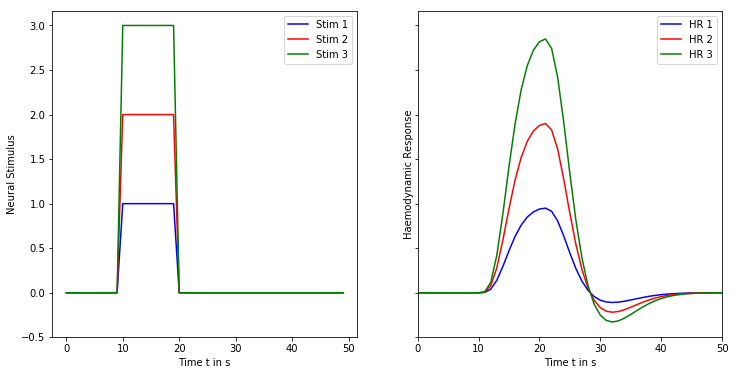

In [ ]:
# a linear time-invariant system satisfies the three properties of addition, scaling and shift-invariants as we'll demonstrate in the following  

f, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=[12,6])
#ax1.plot(x, y)
#ax1.set_title('Sharing Y axis')
#ax2.scatter(x, y)

dt=1
x = np.arange(0,50,dt)
n = np.zeros(len(x))
n[10:20]=1.0
ax1.plot(x,n,'b',label='Stim 1')
ax1.plot(x,2.0*n,'r',label='Stim 2')
ax1.plot(x,3.0*n,'g',label='Stim 3')
ax1.set_ylabel('Neural Stimulus')
ax1.set_xlabel('Time t in s')
ax1.legend()
# hrf
y = np.convolve(n,spm_hrf_compat(np.arange(0,32,dt),normalize=False))
ax2.plot(np.arange(0,len(y)*dt,dt),y,'b',label='HR 1')
ax2.plot(np.arange(0,len(y)*dt,dt),np.convolve(2.0*n,spm_hrf_compat(np.arange(0,32,dt),normalize=False)),'r',label='HR 2')
ax2.plot(np.arange(0,len(y)*dt,dt),np.convolve(3.0*n,spm_hrf_compat(np.arange(0,32,dt),normalize=False)),'g',label='HR 3')
ax2.set_ylabel('Haemodynamic Response')
ax2.set_xlabel('Time t in s')
ax2.legend()
ax2.set_xlim(0,50)
filename='LTI2.png'
f.savefig(filename)
files.download(filename)

<Figure size 1440x216 with 0 Axes>

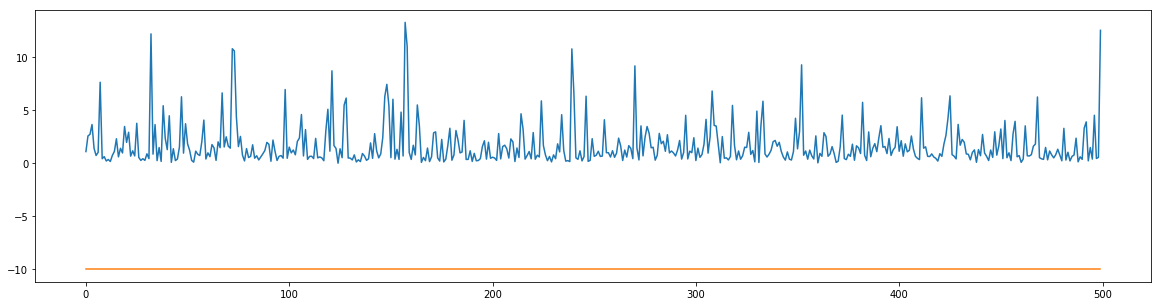

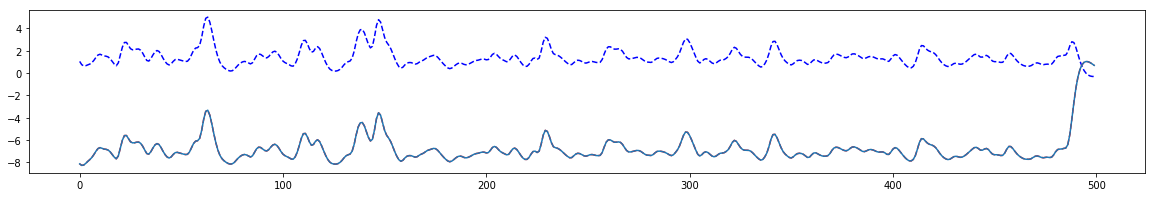

In [ ]:
# convolution properties equivariance re. baseline
dt=1
plt.figure(figsize=(20,3))
x = np.arange(0,500,dt)
n = np.exp(np.random.randn(len(x)))
b = -10.0*np.ones(len(n))
hrf = spm_hrf_compat(np.arange(0,32,dt),normalize=False)

plt.figure(figsize=(20,5))

plt.plot(n)
plt.plot(b)

plt.figure(figsize=(20,3))

y = np.convolve(n,hrf,'same')
y_baseline_shift = np.convolve(n-10.0,hrf,'same')
y_baseline = np.convolve(b,hrf,'same')

plt.plot(np.arange(0,len(y)*dt,dt),y,'b--')
plt.plot(np.arange(0,len(y)*dt,dt),y+y_baseline,'r--')
plt.plot(np.arange(0,len(y_baseline_shift)*dt,dt),y_baseline_shift)

<Figure size 1440x216 with 0 Axes>

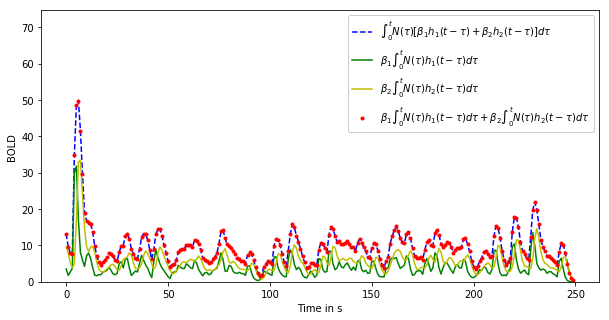

In [ ]:
# convolution properties equivariance re. baseline
dt=2
plt.figure(figsize=(20,3))
x = np.arange(0,500,dt)
n = np.exp(np.random.randn(len(x)))
h1_ = h1(np.arange(0,32,dt))
h2_ = h2(np.arange(0,32,dt))

y = np.convolve(n,h1_+h2_,'same')
y1 = np.convolve(n,h1_,'same')
y2 = np.convolve(n,h2_,'same')

plt.figure(figsize=(10,5))
#plt.stem(n)
plt.plot(y,'b--',label=r'$\int _ { 0 } ^ { t } N ( \tau ) \left[ \beta _ { 1 } h _ { 1 } ( t - \tau ) + \beta _ { 2 } h _ { 2 } ( t - \tau )\right] d \tau$')
plt.plot(y1,'g-',label=r'$\beta _ { 1 } \int _ { 0 } ^ { t } N ( \tau ) h _ { 1 } ( t - \tau ) d \tau$')
plt.plot(y2,'y-',label=r'$\beta _ { 2 } \int _ { 0 } ^ { t } N ( \tau ) h _ { 2 } ( t - \tau ) d \tau$')
plt.plot(y1+y2,'r.', label=r'$\beta _ { 1 } \int _ { 0 } ^ { t } N ( \tau ) h _ { 1 } ( t - \tau ) d \tau + \beta _ { 2 } \int _ { 0 } ^ { t } N ( \tau ) h _ { 2 } ( t - \tau ) d \tau$')
plt.legend(loc='upper right', frameon=True, framealpha=1.0, facecolor='w')
plt.xlabel('Time in s')
plt.ylabel('BOLD')
plt.ylim(0,np.max(y)*1.5)
filename='LTI3.png'
plt.savefig(filename)
files.download(filename)

/usr/local/lib/python2.7/dist-packages/numpy/core/numeric.py:538: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


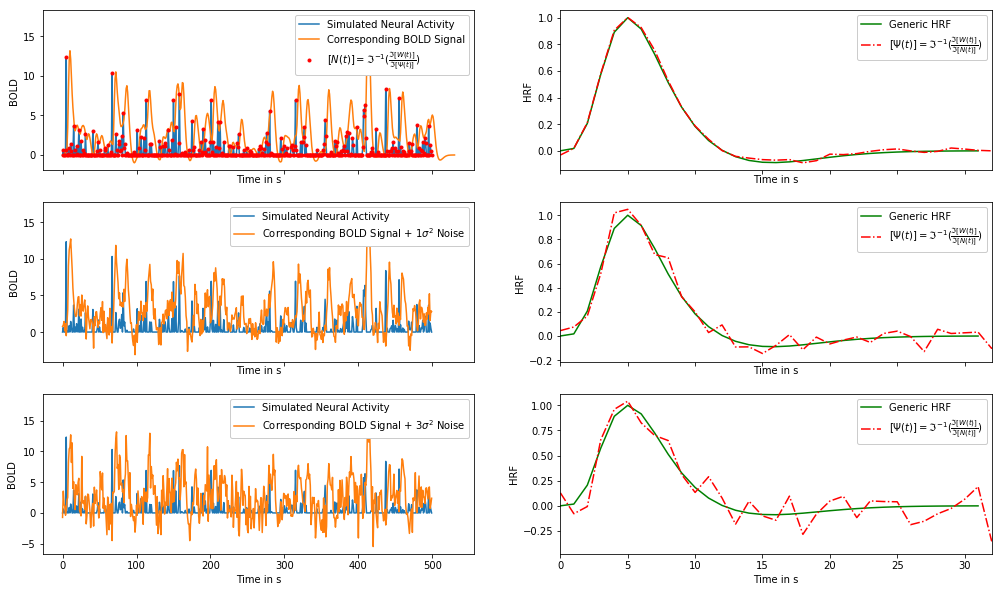

In [ ]:
f, ((ax1, ax2), (ax3, ax4),(ax5, ax6)) = plt.subplots(3, 2, sharex='col', figsize=[17,10])
n = np.zeros(500)
dt = 1.0
n[10:500:32] = 1.0
n = np.random.binomial(n=1,p=0.33,size=500).astype(np.float32)
n *= np.exp(np.random.randn(500))
hrf = spm_hrf_compat(np.arange(0,32,dt),normalize=False)
hrf /= hrf.max()
y = np.convolve(n,hrf)
ax1.plot(n,label='Simulated Neural Activity')
ax1.plot(y,label='Corresponding BOLD Signal')

hrf_list = list()
for i in range(10,500-32,10):
  hrf_list.append(np.fft.ifft(np.fft.fft(y[i:i+32])/np.fft.fft(n[i:i+32])))
  
y_valid = np.convolve(n,hrf)[:500]
hrf_recovered_all_together = np.fft.ifft(np.fft.fft(y_valid)/np.fft.fft(n))
hrf_recovered = np.concatenate(hrf_list).reshape(-1,32).T

n_recovered = np.fft.ifft(np.fft.fft(y_valid)/np.fft.fft(hrf_recovered_all_together))
ax1.plot(range(len(n_recovered)),n_recovered,'r.',label=r'$[ N ( t ) ] = \Im ^{-1}(\frac { \Im [ W ( t ) ] } { \Im [ \Psi ( t ) ] })$')
ax1.set_xlabel('Time in s')
ax1.set_ylabel('BOLD')
ax1.legend(loc='upper right', frameon=True, framealpha=1.0, facecolor='w')

#ax2.plot(hrf_recovered);
ax2.plot(hrf,'g-',label='Generic HRF')
ax2.plot(hrf_recovered_all_together, 'r-.', label=r'$[ \Psi ( t ) ] = \Im ^{-1}(\frac { \Im [ W ( t ) ] } { \Im [ N ( t ) ] })$');
ax2.set_xlim(0,32.0)
ax2.set_xlabel('Time in s')
ax2.set_ylabel('HRF')
ax2.legend(loc='upper right', frameon=True, framealpha=1.0, facecolor='w')

y = np.convolve(n,hrf)[:500]
y += np.random.randn(len(y))
hrf_ = np.fft.ifft(np.fft.fft(y)/np.fft.fft(n))

#n_recovered = np.fft.ifft(np.fft.fft(y)/np.fft.fft(hrf_recovered_all_together))
#ax3.plot(range(len(n_recovered)),n_recovered,'r-.')

ax3.plot(n,label='Simulated Neural Activity')
ax3.plot(y,label='Corresponding BOLD Signal + 1$\sigma^2$ Noise')
ax3.set_xlabel('Time in s')
ax3.set_ylabel('BOLD')
ax3.legend(loc='upper right', frameon=True, framealpha=1.0, facecolor='w')
hrf_list = list()
for i in range(10,500-32,10):
  hrf_list.append(np.fft.ifft(np.fft.fft(y[i:i+32])/np.fft.fft(n[i:i+32])))
  
#hrf_recovered = np.concatenate(hrf_list).reshape(-1,32).T
#ax4.plot(hrf_recovered/hrf_recovered.max(axis=0));
#ax4.plot(hrf_recovered.mean(axis=1)/hrf_recovered.mean(axis=1).max(),'b--')
ax4.plot(hrf,'g-',label='Generic HRF')
ax4.plot(hrf_,'r-.', label=r'$[ \Psi ( t ) ] = \Im ^{-1}(\frac { \Im [ W ( t ) ] } { \Im [ N ( t ) ] })$');
ax4.set_xlim(0,32.0)
ax4.set_xlabel('Time in s')
ax4.set_ylabel('HRF')
ax4.legend(loc='upper right', frameon=True, framealpha=1.0, facecolor='w')

y += 2.0*np.random.randn(len(y))
hrf_ = np.fft.ifft(np.fft.fft(y)/np.fft.fft(n))
ax5.plot(n,label='Simulated Neural Activity')
ax5.plot(y,label='Corresponding BOLD Signal + 3$\sigma^2$ Noise')
ax5.set_xlabel('Time in s')
ax5.set_ylabel('BOLD')
ax5.legend(loc='upper right', frameon=True, framealpha=1.0, facecolor='w')
hrf_list = list()
for i in range(10,500-32,10):
  hrf_list.append(np.fft.ifft(np.fft.fft(y[i:i+32])/np.fft.fft(n[i:i+32])))
  
#hrf_recovered = np.concatenate(hrf_list).reshape(-1,32).T
#ax6.plot(hrf_recovered/hrf_recovered.max(axis=0));
#ax6.plot(hrf_recovered.mean(axis=1)/hrf_recovered.mean(axis=1).max(),'b--')
ax6.plot(hrf,'g-',label='Generic HRF')
ax6.plot(hrf_,'r-.', label=r'$[ \Psi ( t ) ] = \Im ^{-1}(\frac { \Im [ W ( t ) ] } { \Im [ N ( t ) ] })$');
ax6.set_xlim(0,32.0)
ax6.set_xlabel('Time in s')
ax6.set_ylabel('HRF')
ax6.legend(loc='upper right', frameon=True, framealpha=1.0, facecolor='w')
filename='Deconvolution.png'
f.savefig(filename)
files.download(filename)

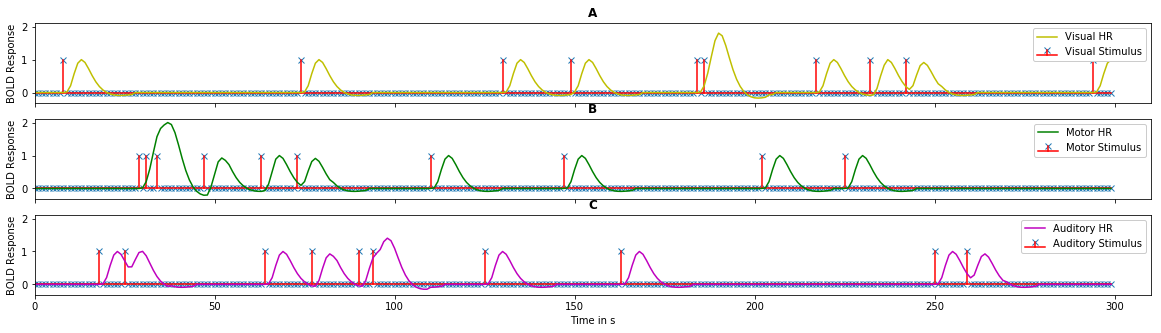

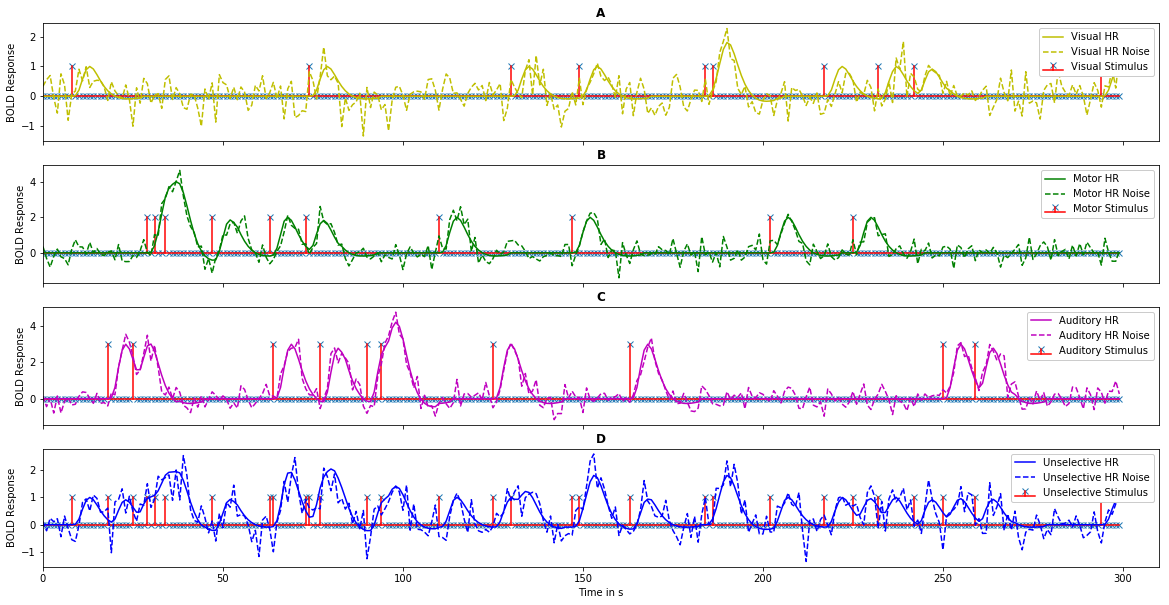

In [ ]:
import scipy
def filter2toeplitz(timepoints,h,mode='same'):
    padding = np.zeros(timepoints-1, h.dtype)
    first_col = np.r_[h, padding]
    first_row = np.r_[h[0], padding]
    H = scipy.linalg.toeplitz(first_col, first_row)[0:timepoints,:]
    return H

SNR = 10.0
dt = 1.0
hrf = spm_hrf_compat(np.arange(0,20,dt),normalize=False)
hrf /= hrf.max()

vols_per_stim = 30;
n_repeats = 10;
n_volumes = vols_per_stim * n_repeats
H = filter2toeplitz(n_volumes, hrf)
n_conditions = 3
n_voxels = 4
onsets = np.random.permutation(n_volumes)
stims = np.zeros((n_volumes,n_conditions))
for i in range(3):
  stims[onsets[i*n_repeats:(i+1)*n_repeats],i] = 1.0
  
  
# Reusable labels
c_and_d = ['y-','g-','m-','b-']
labels = ['Visual HR','Motor HR','Auditory HR','Unselective HR']
labels_neural = ['Visual Stimulus','Motor Stimulus','Auditory Stimulus','Unselective Stimulus']
title_labels = [r'$\mathbf{A}$',r'$\mathbf{B}$',r'$\mathbf{C}$',r'$\mathbf{D}$']

X = H.dot(stims)
f, axes = plt.subplots(3, 1, figsize=[20,5], sharex=True, sharey=True)
for i in range(3):
  axes[i].stem(stims[:,i],linefmt='r-',label=labels_neural[i], markerfmt='x', basefmt='r-');
  axes[i].plot(X[:,i],c_and_d[i],label=labels[i]);
  if i==2:
    axes[i].set_xlabel('Time in s')
  axes[i].set_ylabel('BOLD Response')
  axes[i].set_title(title_labels[i])
  axes[i].legend(loc='upper right', frameon=True, framealpha=1.0, facecolor='w')
  axes[i].set_xlim([0,310])
  

weights = np.array([[1,0,0],[0,2,0],[0,0,3],[1,1,1]])
neural_weighted = stims.dot(weights.T)
bold_weighted = X.dot(weights.T)
noise_std = bold_weighted.max()/SNR;
bold_noise = bold_weighted + noise_std * np.random.randn(bold_weighted.shape[0],bold_weighted.shape[1])

# plot the experiment data
f, axes = plt.subplots(4, 1, figsize=[20,10], sharex=True)
for i in range(4):
  axes[i].stem(neural_weighted[:,i],linefmt='r-',label=labels_neural[i], markerfmt='x', basefmt='r-');
  axes[i].plot(bold_weighted[:,i],c_and_d[i],label=labels[i]);
  axes[i].plot(bold_noise[:,i],c_and_d[i]+'-',label=labels[i]+' Noise');
  if i==3:
    axes[i].set_xlabel('Time in s')
  axes[i].set_ylabel('BOLD Response')
  axes[i].set_title(title_labels[i])
  axes[i].legend(loc='upper right', frameon=True, framealpha=1.0, facecolor='w')
  axes[i].set_xlim([0,310])

Xfir = list()
for i in range(n_conditions):
  Xfir.append(stims[:,i][:,None])
  for h in range(len(hrf)-1):
    Xfir.append(np.pad(stims[:,i],(h+1,0), mode='constant')[:-(h+1),None])

Xfir = np.concatenate(Xfir,axis=1)

hrf1 = h1(np.arange(0,20,dt))
hrf2 = h2(np.arange(0,20,dt))
hrf3 = h3(np.arange(0,20,dt))
H1 = filter2toeplitz(n_volumes,hrf1)
H2 = filter2toeplitz(n_volumes,hrf2)
H3 = filter2toeplitz(n_volumes,hrf3)
X3 = np.concatenate([H1.dot(stims),H2.dot(stims),H3.dot(stims)],axis=1)

beta_fir = ((np.linalg.pinv(Xfir.T.dot(Xfir))).dot(Xfir.T.dot(bold_noise)));
beta_fir_3d = beta_fir.reshape(n_conditions,len(hrf),n_voxels);
beta = (np.linalg.pinv(X.T.dot(X))).dot(X.T.dot(bold_noise))
beta3 = (np.linalg.pinv(X3.T.dot(X3))).dot(X3.T.dot(bold_noise))
#filename='Experiment_Setup.png'
#f.savefig(filename)
#files.download(filename)

(300, 3)
(3, 4)
(4, 3)
[0.05773503 0.05773503 0.05773503]
[ 1. -1.  1.]


<Figure size 432x288 with 0 Axes>

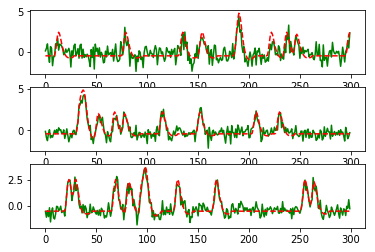

<Figure size 432x288 with 0 Axes>

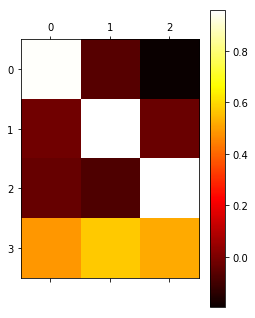

In [ ]:
from sklearn.decomposition import FastICA
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
fastica = FastICA(n_components=3, whiten=True)
pp = (bold_weighted-bold_weighted.mean(axis=0))/bold_weighted.std(axis=0)
pp = (bold_noise-bold_noise.mean(axis=0))/bold_noise.std(axis=0)
H = fastica.fit_transform(pp)
print H.shape
print fastica.components_.shape
print fastica.mixing_.shape
corr = np.corrcoef(X.T,H.T)[3:6,0:3]
order = np.argmax(np.abs(corr),axis=0)
signs = np.zeros(3)
for i in range(3):
  signs[i] = np.sign(corr[order[i],i])
  
plt.figure()
Xs = scaler.fit_transform(X)
Hs = scaler.fit_transform(H)
Hstd = H.std(axis=0)
print Hstd
f, axes = plt.subplots(3,1)
print signs
for i in range(3):
  axes[i].plot(signs[i]*Hs[:,order[i]],'g-')
  axes[i].plot(Xs[:,i],'r--')

plt.figure()
plt.matshow((Hstd*(signs*fastica.mixing_[:,order])), cmap=plt.cm.hot, interpolation='nearest')
plt.colorbar()

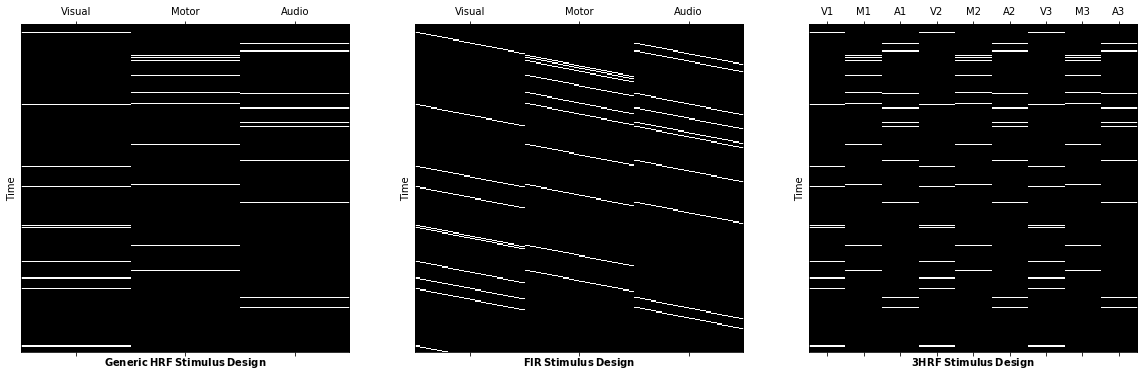

In [ ]:
# plot stimulus designs 
f, (ax1,ax2,ax3) = plt.subplots(1, 3, figsize=[20,7])
ax1.matshow((stims), extent=[0, 3, 0, 3], cmap=plt.cm.gray, interpolation='nearest')
ax1.grid(False)
ax1.set_xticks([0.5,1.5,2.5])
ax1.set_xticklabels(['Visual','Motor','Audio'])
ax1.set_xlabel(r'$\mathbf{Generic\:HRF\:Stimulus\:Design}$')
ax1.set_ylabel('Time')
ax1.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
ax2.matshow(Xfir, extent=[0, 3, 0, 3], cmap=plt.cm.gray, interpolation='nearest')
ax2.grid(False)
ax2.set_xticks([0.5,1.5,2.5])
ax2.set_xticklabels(['Visual','Motor','Audio'])
ax2.set_xlabel(r'$\mathbf{FIR\:Stimulus\:Design}$')
ax2.set_ylabel('Time')
ax2.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
ax3.matshow(np.concatenate([stims,stims,stims],axis=1), extent=[0, 9, 0, 9], cmap=plt.cm.gray, interpolation='nearest')
ax3.grid(False)
ax3.set_xticks(np.arange(0.5,9,1.0))
ax3.set_xlabel(r'$\mathbf{3HRF\:Stimulus\:Design}$')
ax3.set_ylabel('Time')
ax3.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
ax3.set_xticklabels(['V1','M1','A1','V2','M2','A2','V3','M3','A3']);
filename='Designs.png'
f.savefig(filename)
files.download(filename)

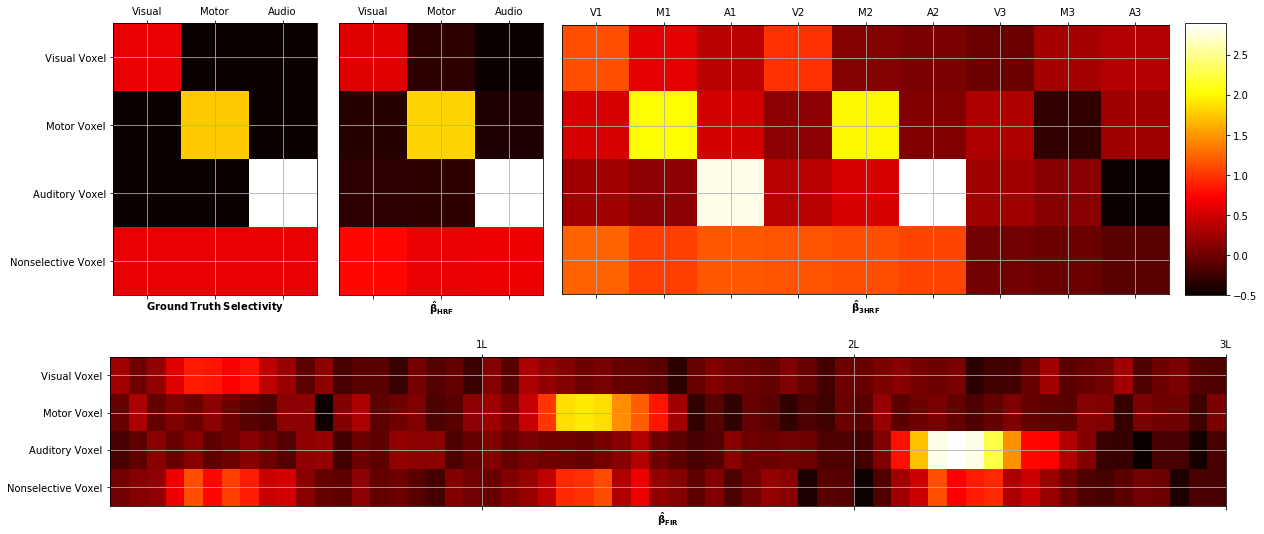

In [ ]:
# plot beta coefficients
plt.figure(figsize=[20,10], frameon=False)
grid = plt.GridSpec(2, 20, wspace=0.4, hspace=0.0)
f = plt.subplot(grid[0, 0:4])
f.matshow(weights, cmap=plt.cm.hot, interpolation='nearest')
f.set_xticks([0,1,2])
f.set_yticks([0,1,2,3])
f.set_xlabel(r'$\mathbf{Ground\:Truth\:Selectivity}$')
f.set_yticklabels(['Visual Voxel','Motor Voxel','Auditory Voxel','Nonselective Voxel'])
f.set_xticklabels(['Visual','Motor','Audio'])
f.grid(True)
#f.set_ylabel('Voxels')
#f.colorbar()
f = plt.subplot(grid[0, 4:8])
f.matshow(beta.T, cmap=plt.cm.hot, interpolation='nearest')
f.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
f.set_xlabel(r'$\mathbf{\hat{\beta}_{HRF}}$')
f.set_xticks([0,1,2])
f.set_xticklabels(['Visual','Motor','Audio'])
f.grid(True)
#f.colorbar()
f = plt.subplot(grid[0, 8:19])
f.matshow(beta3.T, cmap=plt.cm.hot, interpolation='nearest')
f.tick_params(axis='y',which='both',left=False,right=False,labelleft=False)
f.set_xticks(range(9))
f.set_xticklabels(['V1','M1','A1','V2','M2','A2','V3','M3','A3']);
f.grid(True)
f.set_xlabel(r'$\mathbf{\hat{\beta}_{3HRF}}$')
#f.colorbar()
axes = plt.subplot(grid[1, 0::20])
#axes.matshow(beta_fir.reshape(-1,n_voxels).T)
pc = axes.matshow(beta_fir.T, extent=[0, 30, 0, 4], cmap=plt.cm.hot, interpolation='nearest')
axes.set_xlabel(r'$\mathbf{\hat{\beta}_{FIR}}$')
#axes.set_yticklabels(['3','2','1','0'])
axes.set_xticks([10,20,30])
axes.set_xticklabels(['1L','2L','3L'])
axes.set_yticks([0.5,1.5,2.5,3.5])
axes.set_yticklabels(['Nonselective Voxel','Auditory Voxel','Motor Voxel','Visual Voxel'])
axes.grid(True,axis='both')
axes = plt.subplot(grid[0, 19])
plt.colorbar(pc,cax=axes)
filename='Beta_Estimates.png'
plt.savefig(filename)
files.download(filename)

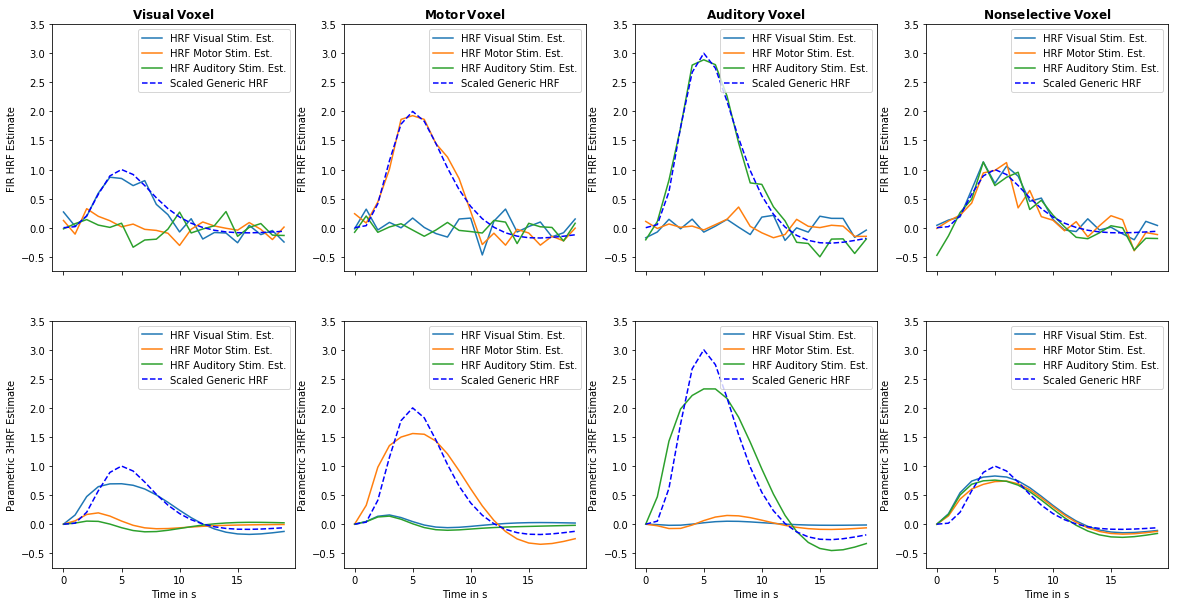

In [ ]:
scaling = [1.0,2.0,3.0,1.0]
fig, axes = plt.subplots(2,4,figsize=[20,10], sharex=True)
voxel_labels = [r'$\mathbf{Visual\:Voxel}$',r'$\mathbf{Motor\:Voxel}$',r'$\mathbf{Auditory\:Voxel}$',r'$\mathbf{Nonselective\:Voxel}$']
for i in range(4):
  timecourses = np.squeeze(beta_fir_3d[:,:,i]).T
  axes[0][i].plot(np.arange(0,len(hrf))*dt,timecourses[:,0],label='HRF Visual Stim. Est.');
  axes[0][i].plot(np.arange(0,len(hrf))*dt,timecourses[:,1],label='HRF Motor Stim. Est.');
  axes[0][i].plot(np.arange(0,len(hrf))*dt,timecourses[:,2],label='HRF Auditory Stim. Est.');
  axes[0][i].plot(np.arange(0,len(hrf))*dt,scaling[i]*hrf,'b--',label='Scaled Generic HRF')
  axes[0][i].set_ylim([-.75,3.5])
  axes[0][i].legend()
  axes[0][i].set_ylabel('FIR HRF Estimate')
  axes[0][i].set_title(voxel_labels[i])
  #axes[0][i].set_xlabel('Time in s')
  
for i in range(4):
  one = ((beta3.T)[i,0::3]).dot(np.concatenate([hrf1,hrf2,hrf3]).reshape(3,-1))
  two = ((beta3.T)[i,1::3]).dot(np.concatenate([hrf1,hrf2,hrf3]).reshape(3,-1))
  three = ((beta3.T)[i,2::3]).dot(np.concatenate([hrf1,hrf2,hrf3]).reshape(3,-1))
  axes[1][i].plot(np.arange(0,len(hrf))*dt,one,label='HRF Visual Stim. Est.')
  axes[1][i].plot(np.arange(0,len(hrf))*dt,two,label='HRF Motor Stim. Est.')
  axes[1][i].plot(np.arange(0,len(hrf))*dt,three,label='HRF Auditory Stim. Est.')
  axes[1][i].plot(np.arange(0,len(hrf))*dt,scaling[i]*hrf,'b--',label='Scaled Generic HRF')
  axes[1][i].set_ylim([-.75,3.5])
  axes[1][i].legend()
  axes[1][i].set_ylabel('Parametric 3HRF Estimate')
  #axes[1][i].set_title(voxel_labels[i])
  axes[1][i].set_xlabel('Time in s')
  
filename='beta_reshaped.png'
fig.savefig(filename)
files.download(filename)

# Experiments Haemodynamic Response